In [59]:
from collections import Counter
import numpy as np
import sklearn.datasets as Datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return (-np.sum(p * np.log2(p) for p in ps if p > 0))


In [11]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.right = right
        self.left = left
        self.value = value

    def is_leaf_node(self):
        return (self.value is not None)

In [12]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
    
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)
        
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Greedy search for best split
        best_feat, best_thres = self.best_criteria(X, y, feat_idxs)

        left_idxs, right_idxs = self.split(X[:, best_feat], best_thres)

        left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        
        return Node(best_feat, best_thres, left, right)

    def best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thres = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self.information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thres = threshold
        return split_idx, split_thres

    def information_gain(self, y, X_column, split_thres):
        # Calculate entropy
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self.split(X_column, split_thres)
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # Weighted average of child entropy
        n = len(y)
        n_r, n_l = len(right_idxs), len(left_idxs)
        e_r, e_l = entropy(y[right_idxs]), entropy(y[left_idxs])
        child_entropy = (n_r / n) * e_r + (n_l / n) * e_l

        # Information gain
        return parent_entropy - child_entropy

    def split(self, X_column, split_threh):
        left_idxs = np.argwhere(X_column <= split_threh).flatten()
        right_idxs = np.argwhere(X_column > split_threh).flatten()
        return left_idxs, right_idxs

    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    def predict(self, X):
        return np.array([self.transverse_tree(x, self.root) for x in X])
        
    def transverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self.transverse_tree(x, node.left)
        return self.transverse_tree(x, node.right)


In [ ]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[idxs], y[idxs]

In [15]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [27]:
from sklearn import tree

In [34]:
class RandomForest:
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_feats=self.n_feats)
            X_sample, y_sample = bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [35]:
def accuracy(y_true, y_pred):
    return np.sum(y_pred == y_true) / len(y_true)


In [36]:
# Load and split data
data = Datasets.load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [37]:
# Train and evaluate the RandomForest model
clf_f = RandomForest(n_trees=3)
clf_f.fit(X_train, y_train)
y_pred = clf_f.predict(X_test)
acc = accuracy(y_test, y_pred)

/tmp/ipykernel_15035/3108087467.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (-np.sum(p * np.log2(p) for p in ps if p > 0))


In [38]:

print("Accuracy: ", acc)

Accuracy:  0.9473684210526315


In [40]:
plt.style.use('dark_background')


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [51]:
# Load data
data = load_breast_cancer()
X = data.data
y = data.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf_f = RandomForestClassifier(n_estimators=3, random_state=42)
clf_f.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [52]:
# Predict on the test set
y_pred = clf_f.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.956140350877193


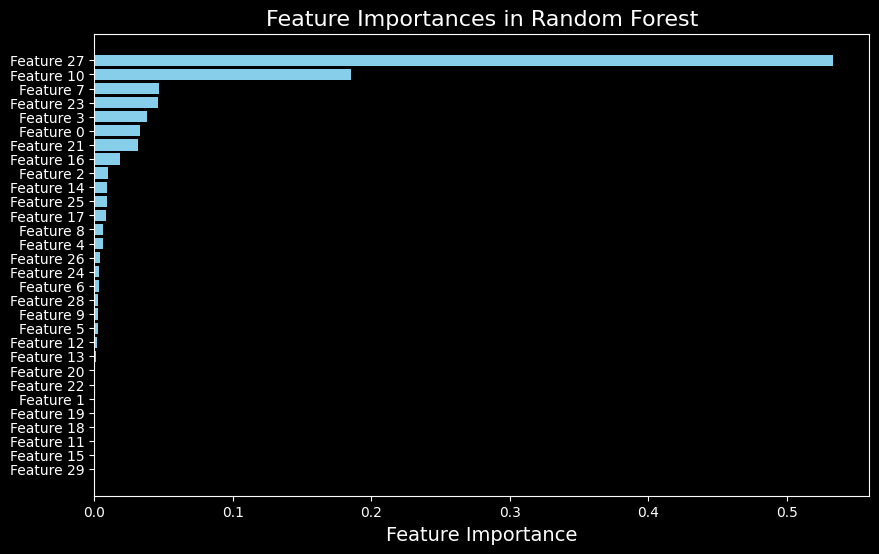

In [53]:
# Feature Importance Plot
def plot_feature_importance(model, X):
    importances = model.feature_importances_
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    
    # Sort feature importances
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color='skyblue')
    plt.xlabel('Feature Importance', fontsize=14)
    plt.title('Feature Importances in Random Forest', fontsize=16)
    plt.show()

plot_feature_importance(clf_f, X_train)

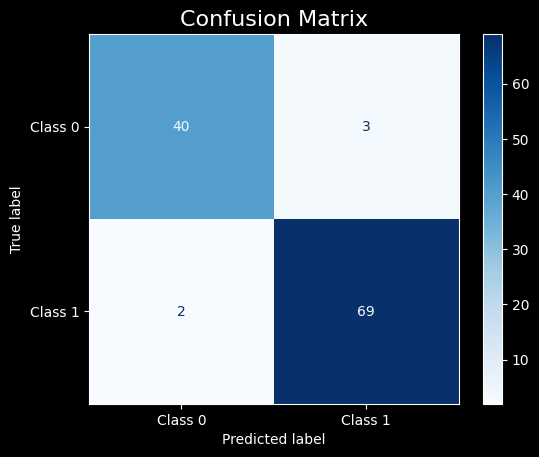

In [54]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

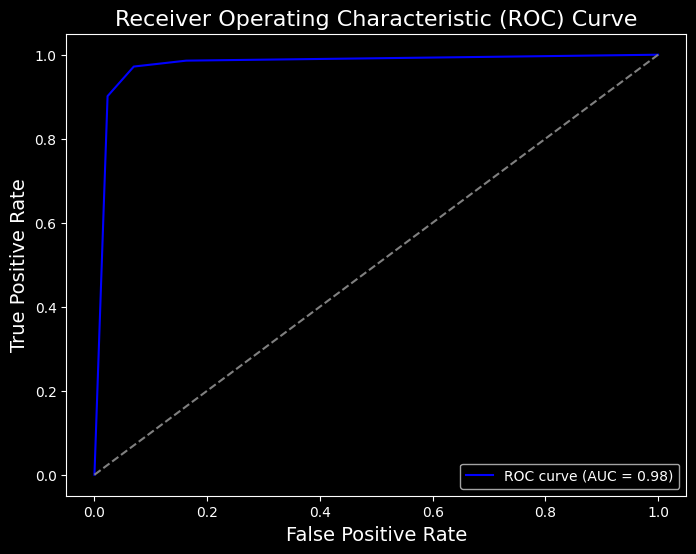

In [56]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, clf_f.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.show()

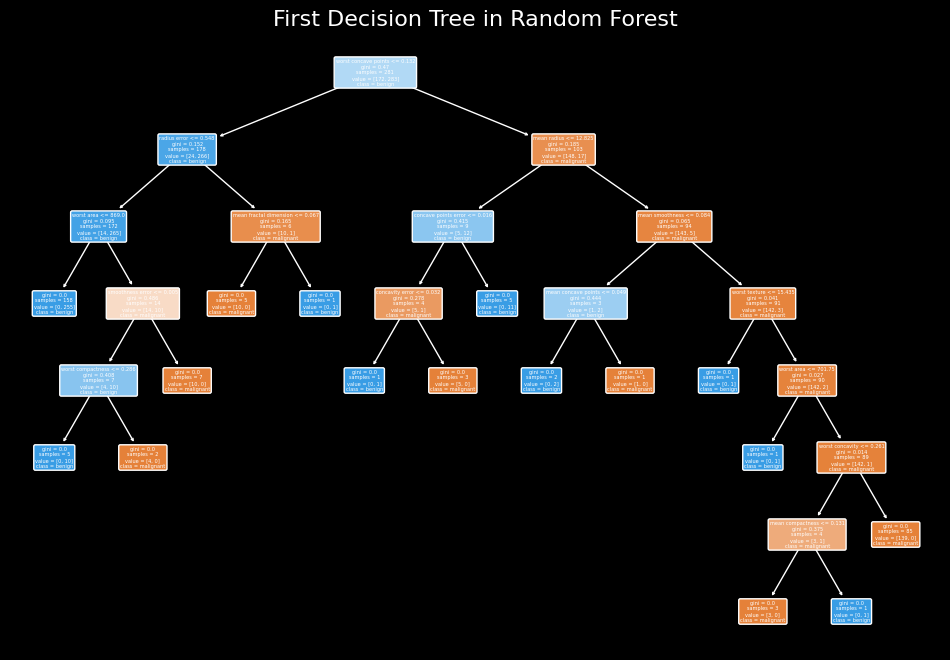

In [57]:
# Plot the first Decision Tree in the Random Forest
# Here we select the first tree and plot it using plot_tree from sklearn
plt.figure(figsize=(12, 8))
plot_tree(clf_f.estimators_[0], filled=True, feature_names=data.feature_names, class_names=data.target_names, rounded=True)
plt.title('First Decision Tree in Random Forest', fontsize=16)
plt.show()